In [23]:
%reload_ext autoreload
%autoreload 2

%matplotlib widget

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.files import results_dir
from src.plotting import errorPlot
from src.iaf.analysis import gather_metadata, gather_results, gather_rates, gather_weights

In [2]:
# Gotta add the config files to the run data (see new iaf_correlation.py script!!!)

In [2]:
experiment_folder = results_dir("iaf_runs") / "correlated" / "20250324"
metadata = gather_metadata(experiment_folder, experiment_type="correlation")
firing_rates = gather_rates(metadata, experiment_type="correlation")
weights = gather_weights(metadata, experiment_type="correlation", average_method="fraction", average_window=0.2, normalize=True)

In [3]:
results = gather_results(metadata)

In [4]:
firing_rates.shape

(5, 1, 1, 2400)

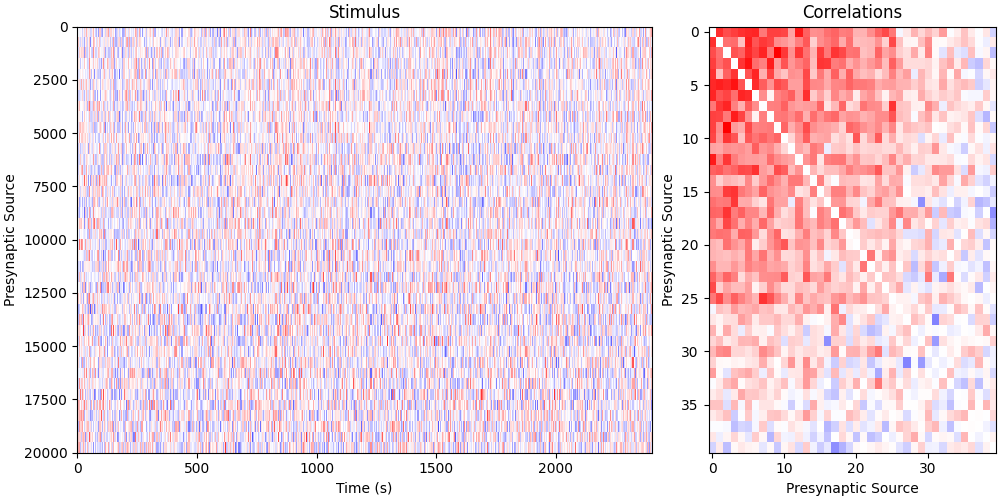

In [70]:
def construct_stimulus(results, source_name: str):
    source_rates = results["source_rates"][source_name]
    source_intervals = results["source_intervals"][source_name]
    steps_per_second = int(1 / results["sim"].dt)
    seconds = results["weights"][0]["proximal"].shape[0]
    num_steps = seconds * steps_per_second
    full_rates = np.zeros((num_steps, source_rates.shape[1]))
    next_position = 0
    for interval, rate in zip(source_intervals, source_rates):
        full_rates[next_position:next_position+interval, :] = rate
        next_position += interval
    return full_rates

istim = 2
stim = construct_stimulus(results[istim], "excitatory")[:20000]
stim = sp.stats.zscore(stim, axis=0)
cc = np.corrcoef(stim, rowvar=False)
cc = cc - np.eye(cc.shape[0])
vmax = np.max(np.abs(np.triu(cc, 1)))
duration = firing_rates.shape[-1]
extent = lambda y: [0, duration, y, 0]

evals, evecs = np.linalg.eigh(cc)
idxsort = np.argsort(-evals)
evals = evals[idxsort]
evecs = evecs[:, idxsort]
num_dims = 20
trans = evecs[:, :num_dims]
trans_matrix = trans @ trans.T
stim_reduced = stim @ trans_matrix

stim_to_plot = stim_reduced.T
max_stim = np.max(np.abs(stim_to_plot))
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained", width_ratios=[2, 1])
ax[0].imshow(stim_to_plot, cmap="bwr", extent=extent(stim_to_plot.shape[1]), interpolation="none", aspect="auto", origin="upper", vmin=-max_stim, vmax=max_stim)
ax[0].set_title("Stimulus")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Presynaptic Source")
ax[1].imshow(cc, cmap="bwr", aspect="auto", interpolation="none", vmin=-vmax, vmax=vmax, origin="upper")
ax[1].set_title("Correlations")
ax[1].set_xlabel("Presynaptic Source")
ax[1].set_ylabel("Presynaptic Source")
plt.show()

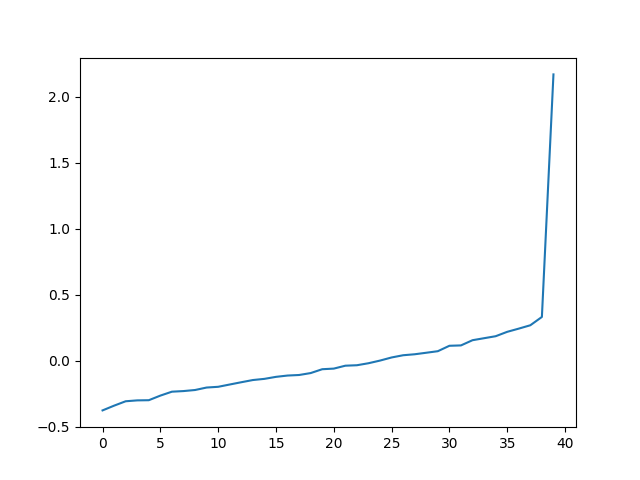

In [38]:
plt.close('all')
plt.plot(evals)
plt.show()


In [31]:
weights

{'proximal': array([[[[0.83553653, 0.83387614, 0.81633159, 0.90857058, 0.78410517,
           0.87451511, 0.59173616, 0.77136497, 0.5774687 , 0.67879558,
           0.70821175, 0.21453612, 0.47604657, 0.36320447, 0.34582881,
           0.33367312, 0.13085057, 0.15966127, 0.21509156, 0.1718925 ,
           0.27701206, 0.17762332, 0.09422386, 0.08067779, 0.07014257,
           0.05649151, 0.07071247, 0.05784144, 0.06560056, 0.0628275 ,
           0.06731473, 0.0628914 , 0.05404137, 0.06373379, 0.048955  ,
           0.05236882, 0.04530797, 0.05732874, 0.05157899, 0.04042661]]],
 
 
        [[[0.87696058, 0.78158695, 0.89771112, 0.85711463, 0.63735197,
           0.55010672, 0.3901399 , 0.71807855, 0.75686897, 0.7197916 ,
           0.69165192, 0.84770115, 0.64436528, 0.14328011, 0.25964112,
           0.13260251, 0.19125731, 0.10486749, 0.20533369, 0.10817065,
           0.23836845, 0.11085241, 0.21932614, 0.08664731, 0.14714861,
           0.08374713, 0.12508561, 0.07211726, 0.06211085,

In [15]:
results[0]["source_rates"]["excitatory"].shape

(228437, 40)

In [14]:

results[0]["weights"][0]

{'proximal': array([[8.02978283e-10, 1.02373674e-09, 1.12491107e-09, ...,
         9.81017294e-10, 1.11375715e-09, 9.76619655e-10],
        [7.45031874e-10, 9.89080630e-10, 1.05335293e-09, ...,
         9.29549767e-10, 1.06230902e-09, 9.27848232e-10],
        [6.86152290e-10, 9.45022271e-10, 1.01026616e-09, ...,
         8.72238766e-10, 1.00884301e-09, 8.79521524e-10],
        ...,
        [1.61170223e-09, 1.62559950e-09, 1.78318365e-09, ...,
         8.54504693e-11, 9.06684033e-11, 7.92261302e-11],
        [1.61595714e-09, 1.62650933e-09, 1.79061801e-09, ...,
         8.36397778e-11, 1.05455698e-10, 7.71739048e-11],
        [1.60239501e-09, 1.63178680e-09, 1.79012492e-09, ...,
         1.08673677e-10, 9.82520668e-11, 8.69479475e-11]]),
 'distal-simple': array([[3.04995604e-12, 7.29821498e-12, 7.74627338e-12, ...,
         1.03803168e-12, 5.25269483e-12, 9.37790095e-12],
        [2.44418246e-12, 7.26867855e-12, 7.17406406e-12, ...,
         5.83962702e-13, 4.73479719e-12, 9.11520571e-1

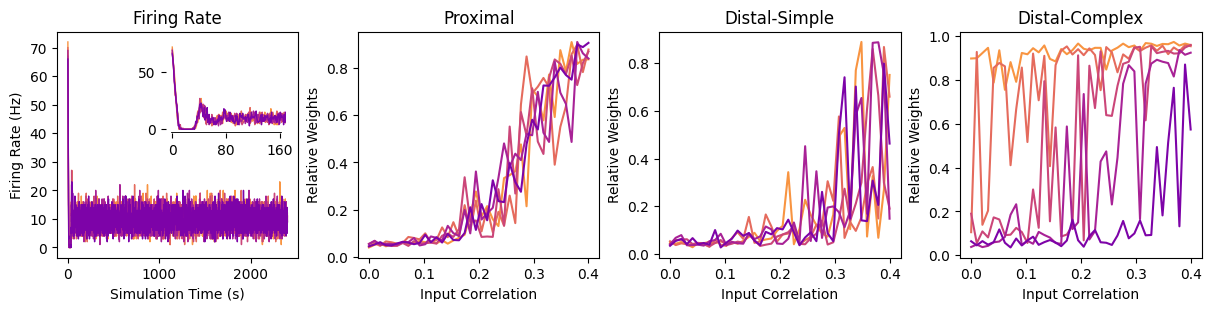

In [5]:
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

num_inputs = metadata["base_config"].sources["excitatory"].num_inputs
max_corr = metadata["base_config"].sources["excitatory"].max_correlation
xvals = np.linspace(max_corr, 0, num_inputs)

fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
inset = ax[0].inset_axes([0.45, 0.55, 0.5, 0.4])
for iratio in range(num_ratios):
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio], axis=1), axis=0, ax=ax[0], color=colors[iratio], linewidth=1.0)
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio], axis=1), axis=0, ax=inset, color=colors[iratio], linewidth=1.0)
    proximal_mean = np.mean(weights["proximal"][iratio], axis=1)  
    distal_simple_mean = np.mean(weights["distal-simple"][iratio], axis=1)
    distal_complex_mean = np.mean(weights["distal-complex"][iratio], axis=1)
    errorPlot(xvals, proximal_mean, axis=0, ax=ax[1], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(xvals, distal_simple_mean, axis=0, ax=ax[2], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(xvals, distal_complex_mean, axis=0, ax=ax[3], color=colors[iratio], alpha=0.2, linewidth=1.5)
ylim0 = ax[0].get_ylim()
inset.set_xlim(-10, 170)
inset.set_xticks([0, 80, 160])
inset.spines["top"].set_visible(False)
inset.spines["right"].set_visible(False)
inset.spines["left"].set_visible(False)
inset.spines["bottom"].set_visible(False)
inset.plot([0, 160], [ylim0[0], ylim0[0]], color="k", linewidth=2.0)
inset.set_ylim(ylim0)
ax[0].set_xlabel("Simulation Time (s)")
ax[0].set_ylabel("Firing Rate (Hz)")
ax[0].set_title("Firing Rate")
for axx, name in zip(ax[1:], ["Proximal", "Distal-Simple", "Distal-Complex"]):
    axx.set_xlabel("Input Correlation")
    axx.set_ylabel("Relative Weights")
    axx.set_title(name)
plt.show()